# Imports

In [1]:
#!pip install numpy-stl

In [2]:
#!pip install -U scikit-learn


In [3]:
#!pip install vtkplotlib

In [4]:
from Transformation import Transformation
import numpy as np
import math
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
import networkx as nx

# Input

In [5]:
transformation = Transformation()

# Create objects
stl_file_path = "3d_models/stl/Handle.stl"
mesh_data = transformation.stl_to_mesh(stl_file_path)
graph = transformation.mesh_to_graph(mesh_data)

transformation.print_graph_properties(graph, display_graph=False, display_labels=False)

Number of nodes: 5999
Number of edges: 17991


In [6]:
print(graph._node)

{(75.0252, -0.66553295, 3.8): {'index_triangle': {0, 6820, 164, 165, 6821, 6822}}, (75.01418, -0.49935842, 16.7): {'index_triangle': {0, 1, 165, 370, 371, 372}}, (75.0, 0.0, 3.8): {'index_triangle': {0, 1, 2, 6658, 6659, 11415, 11416, 11417, 6822, 6823, 6824, 6825, 6826, 6827, 6828, 6829, 6830, 6831, 6832, 6833, 6834, 6835, 6836, 6837, 6838, 6839, 6840, 6841, 6842, 6843, 6844, 6845, 6846, 6847, 6848, 6849, 6850, 6851, 6852, 6853, 6854, 6855, 6856, 6857, 6858, 6859, 6860, 6861, 6862, 6863, 6864, 6865, 6866, 6867, 6868, 6869, 6870, 6871, 6872, 6873, 6874, 6875, 6876, 6877, 6878, 6495}}, (75.00158, 0.16653232, 16.7): {'index_triangle': {1, 2, 3, 372, 373, 374}}, (75.0252, 0.66553295, 3.8): {'index_triangle': {2, 6659, 3, 4, 6660}}, (75.03937, 0.8314692, 16.7): {'index_triangle': {3, 4, 5, 374, 375, 376}}, (75.10067, 1.3272538, 3.8): {'index_triangle': {6660, 6661, 4, 5, 6, 6662}}, (75.12734, 1.4916434, 16.7): {'index_triangle': {5, 6, 7, 376, 377, 378}}, (75.22596, 1.9813722, 3.8): {'inde

# Point Sampler

### DevConv

In [7]:
def relu(array):
    return np.maximum(array, 0)

def sigmoid(array):
    return 1 / (1 + np.exp(-array))

In [8]:
class DevConv():
    def __init__(self, graph, output_dimension):
        self.graph = graph
        self.list_node = list(graph._node)

        self.W_phi = np.random.random((output_dimension))      #change
        self.W_theta = np.array([1, 2, 3])  # change
    
    def forward(self, previous_inclusion_score, return_flatten=True):
        list_inc_score = np.zeros((len(self.list_node), len(self.W_phi)))
        for index_current_node, (current_node, dict_neigh) in enumerate(self.graph._adj.items()):
            # print(index_current_node, " | ", current_node, " | ", dict_neigh)
            neigh_distances = np.zeros(shape=len(dict_neigh))
            for index_neigh, neigh_node in enumerate(dict_neigh.keys()):
                neigh_distances[index_neigh] = np.linalg.norm(np.multiply(self.W_theta, np.array(current_node) - np.array(neigh_node))) # norm(W_theta * (xi - xj))
            list_inc_score[index_current_node] = self.W_phi * np.max(neigh_distances)                                   # W_phi * max(distance)    

        # return if no previous inclusion score
        if len(previous_inclusion_score)==0:
            if return_flatten:
                list_inc_score = list_inc_score.flatten()
            return list_inc_score
        
        # mean the rows if more than one column
        if list_inc_score.shape[1]!=1:
            list_inc_score = np.mean(list_inc_score, axis=1)

        # array of array to array
        if len(list_inc_score.shape)==2:
            if list_inc_score.shape[1]==1:
                list_inc_score = list_inc_score.flatten()

        # Return the mean of previous and current inclusion score
        return np.mean(np.array([previous_inclusion_score, list_inc_score], dtype=np.float64), axis=0)
        

In [9]:
devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]))
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = sigmoid(inclusion_score)
print(inclusion_score)
print(inclusion_score.shape)

[25.95147272 25.95815608 25.95153748 ...  8.15289056 23.39511682
  8.15426886]
[23.29633837 23.30233794 23.2963965  ...  7.31875601 21.0015271
  7.3199933 ]
[0.99999989 0.99999989 0.99999989 ... 0.99346606 0.99999945 0.99347157]
(5999,)


### Multinomial Sampling

In [10]:
normalized_inclusion_score = inclusion_score / np.sum(inclusion_score)  # normalize for multinomial sampling
normalized_inclusion_score = np.round(normalized_inclusion_score, 8)    # round to remove float imprecision

number_throws = 500     # small:more randomness    |   big:less randomness
mult_sampling = np.random.multinomial(number_throws, normalized_inclusion_score)
print(mult_sampling)

[0 0 0 ... 0 0 1]


In [11]:
target_number_point = min(len(graph._node), 50)   # number of points for the simplification

index_k_nodes = np.argpartition(mult_sampling, -target_number_point)[-target_number_point:]
list_k_nodes = np.array(list(graph._node.keys()))[index_k_nodes]
list_k_nodes = [tuple(e) for e in list_k_nodes]
print(list_k_nodes)

[(91.42513, -0.33300498, -2.505017), (76.00676, 8.760632, 90.77871), (76.78342, -7.328478, 84.70014), (77.74096, -6.9390492, 1.8085755), (78.79445, -7.328478, 82.21672), (84.418396, -2.3044074, 95.703064), (75.70341, -7.6759295, 85.64114), (75.0, -8.237194, -1.903447), (84.60808, 8.672658, 84.8882), (92.59843, 0.16653232, 42.5), (90.73905, -5.4119864, 42.5), (79.3726, 8.760632, 89.7817), (92.03719, -3.0965528, 42.5), (78.36945, -6.9390492, 3.445856), (83.13447, -8.774797, 55.4), (77.24825, -7.6759295, 85.094086), (92.497314, -0.33300498, 1.9609579), (76.83378, -0.99710757, -13.647223), (76.512596, 6.7292814, 95.59142), (75.53, -6.9390492, 0.45369837), (91.633286, 4.0099483, 42.5), (75.67042, -7.8332825, -8.992393), (77.195564, 6.0434117, 82.17753), (78.73604, -7.328478, 2.586087), (81.88645, 8.672658, 88.84818), (75.60344, -4.4479885, 82.24519), (76.47152, -4.871695, 55.4), (75.18176, 2.6241417, 81.556725), (89.45155, -4.7321377, 88.56343), (75.82059, -3.710653, 55.4), (81.04928, 8.672

# KNN

In [12]:
XYZ = [list(e) for e in list_k_nodes]
print(XYZ)

[[91.42513, -0.33300498, -2.505017], [76.00676, 8.760632, 90.77871], [76.78342, -7.328478, 84.70014], [77.74096, -6.9390492, 1.8085755], [78.79445, -7.328478, 82.21672], [84.418396, -2.3044074, 95.703064], [75.70341, -7.6759295, 85.64114], [75.0, -8.237194, -1.903447], [84.60808, 8.672658, 84.8882], [92.59843, 0.16653232, 42.5], [90.73905, -5.4119864, 42.5], [79.3726, 8.760632, 89.7817], [92.03719, -3.0965528, 42.5], [78.36945, -6.9390492, 3.445856], [83.13447, -8.774797, 55.4], [77.24825, -7.6759295, 85.094086], [92.497314, -0.33300498, 1.9609579], [76.83378, -0.99710757, -13.647223], [76.512596, 6.7292814, 95.59142], [75.53, -6.9390492, 0.45369837], [91.633286, 4.0099483, 42.5], [75.67042, -7.8332825, -8.992393], [77.195564, 6.0434117, 82.17753], [78.73604, -7.328478, 2.586087], [81.88645, 8.672658, 88.84818], [75.60344, -4.4479885, 82.24519], [76.47152, -4.871695, 55.4], [75.18176, 2.6241417, 81.556725], [89.45155, -4.7321377, 88.56343], [75.82059, -3.710653, 55.4], [81.04928, 8.672

In [13]:
def connect_extended_graph(XYZ, number_neigh=3):
    is_graph_connected = False
    while not is_graph_connected:
        # Create the nearest neighbors object
        _, indices = NearestNeighbors(n_neighbors=number_neigh).fit(XYZ).kneighbors(XYZ)
        # Create the graph from the nearest points
        extended_graph = nx.Graph()
        for index_poly, poly in enumerate(indices):
            for index_current_node in range(len(poly)):
                current_node = list_k_nodes[poly[index_current_node]]
                for index_other_node in range(index_current_node+1, len(poly)):
                    edge = current_node, list_k_nodes[poly[index_other_node]]
                    extended_graph.add_edge(*edge)
                    # if attribute do not exists
                    if len(extended_graph.nodes[current_node])==0:
                        extended_graph.nodes[current_node]['index_poly'] = set()
                    extended_graph.nodes[current_node]['index_poly'].add(index_poly)
        is_graph_connected = nx.is_connected(extended_graph)
        number_neigh += 1
    print("Number of neighbors : ", number_neigh-1)
    return extended_graph

In [14]:
extended_graph = connect_extended_graph(XYZ)

Number of neighbors :  11


Number of nodes: 50
Number of edges: 473


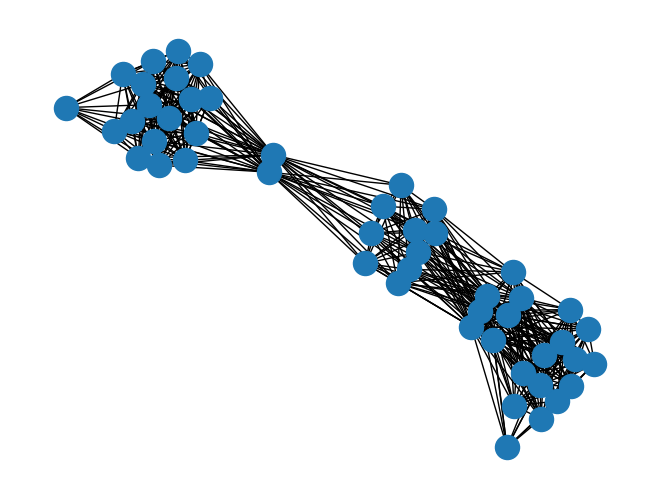

In [15]:
transformation.print_graph_properties(graph=extended_graph, display_graph=True, display_labels=False)

# Edge Predictor

In [16]:
devconv = DevConv(extended_graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]), return_flatten=False)
print(inclusion_score.shape)

(50, 64)


In [17]:
"""
inclusion_score = [[f_1_1  , f_1_2  , ..., f_63_1  ],
                    ...,
                   [f_1_M-1, f_1_M-1, ..., f_63_M-1]]
M = number of points
64 = hidden dimensions
"""
from numpy import mean


f1i = np.mean(inclusion_score)
f1j = np.mean(inclusion_score)
wq = np.random.randint(100, size=(64,1))
wk = np.random.randint(100, size=(1,64))

f1i_wq = f1i*wq
f1j_wk = f1j*wk

wq_wk = int(np.matmul(f1j_wk, f1i_wq)) 

expo = np.exp(wq_wk)



C:\Users\debor\AppData\Local\Temp\ipykernel_9228\73126498.py:21: RuntimeWarning: overflow encountered in exp
  expo = np.exp(wq_wk)


### Sparse Attention

# Face Candidates

# Face Classifier

### TriConv

# Simplified Mesh

# Fonctions Loss

Récupération des points de l'espace de départ P

In [18]:
keys_input = list(graph._node.keys())
print(keys_input)
len(keys_input)  #return 5999

[(75.0252, -0.66553295, 3.8), (75.01418, -0.49935842, 16.7), (75.0, 0.0, 3.8), (75.00158, 0.16653232, 16.7), (75.0252, 0.66553295, 3.8), (75.03937, 0.8314692, 16.7), (75.10067, 1.3272538, 3.8), (75.12734, 1.4916434, 16.7), (75.22596, 1.9813722, 3.8), (75.26499, 2.1432736, 16.7), (75.40037, 2.6241417, 3.8), (75.45153, 2.7826276, 16.7), (75.62288, 3.2518802, 3.8), (75.68588, 3.4060426, 16.7), (75.892235, 3.8609922, 3.8), (75.96672, 4.0099483, 16.7), (76.20689, 4.4479885, 3.8), (76.29242, 4.590885, 16.7), (76.565025, 5.0095077, 3.8), (76.661125, 5.145526, 16.7), (76.96461, 5.5423326, 3.8), (77.07072, 5.670694, 16.7), (77.40334, 6.0434117, 3.8), (77.51886, 6.1633806, 16.7), (77.87872, 6.5098743, 3.8), (78.002975, 6.620764, 16.7), (78.388016, 6.9390492, 3.8), (78.5203, 7.0402236, 16.7), (78.92831, 7.328478, 3.8), (79.06786, 7.4193583, 16.7), (79.4965, 7.6759295, 3.8), (79.64253, 7.755995, 16.7), (80.08935, 7.9794145, 3.8), (80.24101, 8.048206, 16.7), (80.703445, 8.237194, 3.8), (80.859886, 

5999

Récupération des points de l'espace de départ Ps

In [19]:
keys_output = list(extended_graph)
print(keys_output)
len(keys_output)  #return: 50

[(91.42513, -0.33300498, -2.505017), (92.497314, -0.33300498, 1.9609579), (87.233185, -7.5075808, -1.6465638), (89.96338, 6.2811418, 3.8), (85.34132, -0.33300498, -10.433599), (85.57074, 8.114116, -2.3030212), (86.58263, -8.348472, 3.8), (83.571526, -7.8332825, -5.719647), (78.73604, -7.328478, 2.586087), (78.36945, -6.9390492, 3.445856), (77.74096, -6.9390492, 1.8085755), (76.00676, 8.760632, 90.77871), (79.3726, 8.760632, 89.7817), (81.04928, 8.672658, 89.526115), (76.512596, 6.7292814, 95.59142), (81.88645, 8.672658, 88.84818), (77.195564, 6.0434117, 82.17753), (84.60808, 8.672658, 84.8882), (75.18176, 2.6241417, 81.556725), (84.418396, -2.3044074, 95.703064), (75.60344, -4.4479885, 82.24519), (76.78342, -7.328478, 84.70014), (76.96415, -7.328478, 84.60201), (77.24825, -7.6759295, 85.094086), (75.70341, -7.6759295, 85.64114), (78.79445, -7.328478, 82.21672), (75.0, -8.672658, 91.491646), (83.85614, -8.798424, 82.60268), (88.219635, -6.7292814, 87.08576), (89.45155, -4.7321377, 88.56

50

Création de la liste normes entre chaque point

In [22]:
def compare_and_norm(keys_x, keys_y):
    normes_carre = []

    if len(keys_x) >= min(len(keys_x), len(keys_y)) and len(keys_y) >= min(len(keys_x), len(keys_y)):
        # Initialiser une liste pour stocker les normes au carré calculées

        # Iterer sur les 50 premiers points des deux listes
        for i in range(min(len(keys_x), len(keys_y))):
            # Convertir les tuples en arrays NumPy pour le calcul de la norme
            keys_x = np.array(keys_input[i])
            keys_y = np.array(keys_output[i])

            # Calculer la norme euclidienne au carré
            norme_carre = np.linalg.norm(keys_x - keys_y)**2

            # Ajouter la norme au carré à la liste
            normes_carre.append(norme_carre)

            # Afficher les informations
            # print(f"Point {i+1}: Keys Input: {keys_input[i]}, Keys Output: {keys_output[i]}, Norme: {norme}")
    else:
        print("Erreur : Les listes n'ont pas assez de points.")

    return normes_carre


In [23]:
normes_list = compare_and_norm(keys_input, keys_output)
print(normes_list)
len(normes_list)

[308.821589487201, 522.9269318458537, 235.679636165195, 427.6538927669171, 310.0146555884603, 525.061515326528, 225.45498938254696, 660.8990178470012, 100.46754045064154, 267.7986096682471, 100.89875031610518, 5523.699370119721, 7437.258276676352, 5360.146345065965, 8434.278030733636, 5262.143603649223, 6146.559042968787, 4735.4415592039, 6053.711862448603, 6357.1605521981255, 6255.307170940796, 4793.079644266749, 6707.965167970455, 4869.351511739718, 6903.941152168496, 4487.648569746176, 7945.028204455972, 4622.496643208957, 7220.4664096571505, 5419.832910111232, 240.52848393605473, 562.3357370887097, 321.40913095418364, 270.1788655782584, 55.224370944544944, 947.1292466800114, 1693.1276684921613, 911.0812260766725, 1612.0125139772572, 937.0453522602074, 2968.976119280793, 1723.1452006789768, 2874.6735317932907, 1678.8229556894512, 4213.102564738132, 2697.1373858984007, 460.4230980877219, 368.27105427321294, 2586.4932682609797, 5661.308708936907]


50